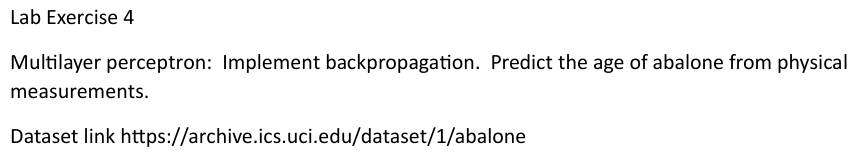

# Imports

In [1]:
!pip install ucimlrepo

import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo

# Load abalone data

In [2]:
abalone = fetch_ucirepo(id=1)
X = abalone.data.features
y = abalone.data.targets
df = pd.concat([X, y], axis=1)


[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


MLP Class

In [3]:
class MLP:
    def __init__(self, layers, lr=0.01, activ='sigmoid'):
        self.layers = layers
        self.lr = lr
        self.activ = activ
        self.n_layer = len(layers)
        
        self.weights = []
        self.biases = []
        
        np.random.seed(42)
        for i in range(self.n_layer - 1):
            w = np.random.randn(layers[i], layers[i + 1]) * 0.1
            b = np.zeros((1, layers[i + 1]))
            self.weights.append(w)
            self.biases.append(b)
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))
    
    def sig_grad(self, a):
        return a * (1 - a)
    
    def tanh(self, z):
        return np.tanh(z)
    
    def tanh_grad(self, a):
        return 1 - a ** 2
    
    def relu(self, z):
        return np.maximum(0, z)
    
    def relu_grad(self, a):
        return (a > 0).astype(float)
    
    def activate(self, z):
        if self.activ == 'sigmoid':
            return self.sigmoid(z)
        elif self.activ == 'tanh':
            return self.tanh(z)
        elif self.activ == 'relu':
            return self.relu(z)
    
    def act_grad(self, a):
        if self.activ == 'sigmoid':
            return self.sig_grad(a)
        elif self.activ == 'tanh':
            return self.tanh_grad(a)
        elif self.activ == 'relu':
            return self.relu_grad(a)
    
    def forward(self, X):
        self.acts = [X]
        
        for i in range(self.n_layer - 1):
            z = np.dot(self.acts[-1], self.weights[i]) + self.biases[i]
            
            if i == self.n_layer - 2:
                a = z
            else:
                a = self.activate(z)
            
            self.acts.append(a)
        
        return self.acts[-1]
    
    def backward(self, X, y):
        m = X.shape[0]
        
        output = self.acts[-1]
        delta = output - y
        
        grads_w = []
        grads_b = []
        
        for i in range(self.n_layer - 2, -1, -1):
            grad_w = np.dot(self.acts[i].T, delta) / m
            grad_b = np.sum(delta, axis=0, keepdims=True) / m
            
            grads_w.insert(0, grad_w)
            grads_b.insert(0, grad_b)
            
            if i > 0:
                delta = np.dot(delta, self.weights[i].T) * self.act_grad(self.acts[i])
        
        for i in range(len(self.weights)):
            self.weights[i] -= self.lr * grads_w[i]
            self.biases[i] -= self.lr * grads_b[i]
    
    def fit(self, X_tr, y_tr, X_val, y_val, epochs=1000, batch=32, show=True):
        tr_loss = []
        val_loss = []
        
        for epoch in range(epochs):
            idx = np.arange(X_tr.shape[0])
            np.random.shuffle(idx)
            X_shuf = X_tr[idx]
            y_shuf = y_tr[idx]
            
            for i in range(0, X_tr.shape[0], batch):
                X_b = X_shuf[i:i + batch]
                y_b = y_shuf[i:i + batch]
                
                self.forward(X_b)
                self.backward(X_b, y_b)
            
            tr_pred = self.predict(X_tr)
            tr_err = np.mean((tr_pred - y_tr) ** 2)
            tr_loss.append(tr_err)
            
            val_pred = self.predict(X_val)
            val_err = np.mean((val_pred - y_val) ** 2)
            val_loss.append(val_err)
            
            if show and (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch + 1}/{epochs} - tr_loss: {tr_err:.4f}, val_loss: {val_err:.4f}")
        
        return tr_loss, val_loss
    
    def predict(self, X):
        return self.forward(X)

# Prepare Data

In [4]:
# Encode categorical variable
sex_enc = pd.get_dummies(df['Sex'], prefix='Sex')

# Prepare features
X_cont = df[['Length', 'Diameter', 'Height', 'Whole_weight',
             'Shucked_weight', 'Viscera_weight', 'Shell_weight']].values
X = np.hstack([sex_enc.values, X_cont])
y = df['Rings'].values.reshape(-1, 1)

# Split data
tr_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_tr = X[:tr_size]
y_tr = y[:tr_size]
X_val = X[tr_size:tr_size + val_size]
y_val = y[tr_size:tr_size + val_size]
X_te = X[tr_size + val_size:]
y_te = y[tr_size + val_size:]

# Normalize features
mu = X_tr.mean(axis=0)
sigma = X_tr.std(axis=0) + 1e-8
X_tr = (X_tr - mu) / sigma
X_val = (X_val - mu) / sigma
X_te = (X_te - mu) / sigma

# Normalize targets
y_mu = y_tr.mean()
y_sig = y_tr.std()
y_tr_norm = (y_tr - y_mu) / y_sig
y_val_norm = (y_val - y_mu) / y_sig

# Training

In [5]:
# Build model
n_input = X_tr.shape[1]
h_layers = [64, 32, 16]
n_output = 1
arch = [n_input] + h_layers + [n_output]

mlp = MLP(layers=arch, lr=0.01, activ='relu')

# Train
tr_loss, val_loss = mlp.fit(
    X_tr, y_tr_norm,
    X_val, y_val_norm,
    epochs=500,
    batch=64,
    show=True
)

Epoch 100/500 - tr_loss: 0.3977, val_loss: 0.3998
Epoch 200/500 - tr_loss: 0.3846, val_loss: 0.3959
Epoch 300/500 - tr_loss: 0.3709, val_loss: 0.3833
Epoch 400/500 - tr_loss: 0.3654, val_loss: 0.3874
Epoch 500/500 - tr_loss: 0.3598, val_loss: 0.3861


# Evaluation

In [6]:
y_pred_norm = mlp.predict(X_te)
y_pred = y_pred_norm * y_sig + y_mu

mse = np.mean((y_pred - y_te) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_pred - y_te))
r2 = 1 - (np.sum((y_te - y_pred) ** 2) / np.sum((y_te - y_te.mean()) ** 2))

print("\nTest set:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2: {r2:.4f}")

print("\nActual | Pred")
for i in range(10):
    print(f"{y_te[i, 0]:6.1f} | {y_pred[i, 0]:6.1f}")


Test set:
MSE: 3.2167
RMSE: 1.7935
MAE: 1.2848
R2: 0.4847

Actual | Pred
   9.0 |    8.8
   8.0 |    8.3
   9.0 |    8.4
   8.0 |    7.8
   9.0 |    8.5
   8.0 |    8.5
   8.0 |   11.4
   9.0 |    8.4
   8.0 |    9.0
  10.0 |   10.1
